# ANÁLISE DE ACESSIBILIDADE EM TERESINA - ATRIBUIÇÃO DE VELOCIDADES
# Autor: Felipe Ramos Dantas
# Data: 23/01/2026

In [1]:
# Célula 1: Imports
import geopandas as gpd
import pandas as pd
import networkx as nx
import momepy  # Essencial para criar o grafo a partir de GeoJSON
from shapely.geometry import Point, Polygon, MultiPoint
import matplotlib.pyplot as plt
import warnings

# Configurações visuais e de sistema
warnings.filterwarnings('ignore') # Ignorar avisos chatos de projeção
pd.set_option('display.max_columns', None)

print("Bibliotecas carregadas com sucesso!")

# Configuração para plots mais legíveis
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

Bibliotecas carregadas com sucesso!


Carregando arquivos...
Reprojetando para UTM Zona 23S (Metros)...
Total de Trechos (Arestas): 56263
Total de Conectores (Nós): 41488


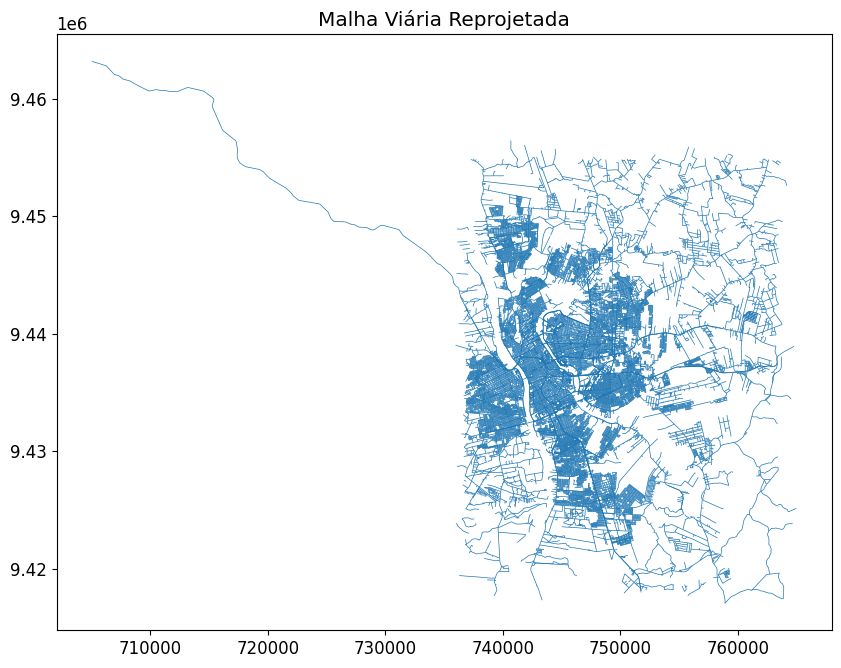

In [2]:
# ============================================
# CARREGAMENTO DA REDE VIÁRIA DE TERESINA
# ============================================

# Célula 2: Carregamento e Projeção
# DEFINA OS CAMINHOS DOS SEUS ARQUIVOS AQUI
caminho_segments = "../dados/brutos/overturemaps/the_bbox_segment.geojson"
caminho_connectors = "../dados/brutos/overturemaps/the_bbox_connector.geojson"

# 1. Carregar os GeoJSONs
print("Carregando arquivos...")
gdf_segments = gpd.read_file(caminho_segments)
gdf_connectors = gpd.read_file(caminho_connectors)

# 2. Definir o Sistema de Referência (CRS) para Teresina (SIRGAS 2000 / UTM 23S)
# EPSG:31983 é o código oficial para sua zona.
CRS_METRICO = "EPSG:31983"

print("Reprojetando para UTM Zona 23S (Metros)...")
gdf_segments = gdf_segments.to_crs(CRS_METRICO)
gdf_connectors = gdf_connectors.to_crs(CRS_METRICO)

# Visualização rápida para confirmar
print(f"Total de Trechos (Arestas): {len(gdf_segments)}")
print(f"Total de Conectores (Nós): {len(gdf_connectors)}")
gdf_segments.plot(linewidth=0.5, figsize=(10, 10))
plt.title("Malha Viária Reprojetada")
plt.show()

In [3]:
display(gdf_segments.tail(3))

,id,version,sources,subtype,class,names,connectors,routes,subclass_rules,access_restrictions,level_rules,destinations,prohibited_transitions,rail_flags,road_surface,road_flags,speed_limits,width_rules,subclass,geometry
56260,79bfa1f6-6731-4b69-bc1e-27e0b889b1c3,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",road,tertiary,"{'primary': 'Rodovia TER-150', 'common': None,...",[{'connector_id': 'dfc2feaf-fac9-44cf-925e-3a0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'value': 'paved', 'between': None}]",NaN,NaN,NaN,NaN,"LINESTRING (737589.666 9454698.76, 737613.262 ..."
56261,fb585452-ddd1-40d9-b9aa-859537b78416,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",road,tertiary,NaN,[{'connector_id': 'e5ef66fb-4d59-4e77-93c5-0f6...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'value': 'paved', 'between': None}]",NaN,NaN,NaN,NaN,"LINESTRING (737743.203 9454812.997, 737716.419..."
56262,cdf9ba35-bb02-41cc-8b5f-e3400e6260c2,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",rail,standard_gauge,"{'primary': 'Ferrovia Transnordestina', 'commo...",[{'connector_id': 'b88b99f4-75e9-416d-b764-0fd...,NaN,NaN,NaN,"[{'value': 1, 'between': [0.04508351, 0.045263...",NaN,NaN,"[{'values': ['is_bridge'], 'between': [0.04508...",NaN,NaN,NaN,NaN,NaN,"LINESTRING (741069.292 9437223.745, 741060.954..."


In [4]:
# 2. Pré-filtro: Remover o que não é estrada
# Overture mistura 'road' e 'rail' no subtype. Vamos ficar só com 'road'.
# Se houver valores nulos em subtype, assumimos que são roads por garantia.
print(f"Total original: {len(gdf_segments)}")
gdf_road = gdf_segments[
    (gdf_segments['subtype'] == 'road') | 
    (gdf_segments['subtype'].isnull())
].copy()

print(f"Total após filtro (apenas 'road'): {len(gdf_road)}")

Total original: 56263
Total após filtro (apenas 'road'): 56223


In [5]:
# 3. Calcular o atributo 'length' (Comprimento)
# Como projetamos para SIRGAS 2000 / UTM 23S (EPSG:31983) na etapa anterior (ou faremos agora),
# o cálculo será em METROS.
# IMPORTANTE: Se o dado ainda estiver em lat/lon (EPSG:4326), precisamos projetar antes.
if gdf_road.crs.to_string() != "EPSG:31983":
    print("Reprojetando para UTM Zona 23S (Metros)...")
    gdf_road = gdf_road.to_crs("EPSG:31983")

gdf_road.insert(7, column='length', value=gdf_road.geometry.length)
print("Coluna 'length' calculada com sucesso.")

display(gdf_road.head(3))

Coluna 'length' calculada com sucesso.


,id,version,sources,subtype,class,names,connectors,length,routes,subclass_rules,access_restrictions,level_rules,destinations,prohibited_transitions,rail_flags,road_surface,road_flags,speed_limits,width_rules,subclass,geometry
0,effc0f97-d37e-42d0-9229-b1af5b811c78,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",road,path,NaN,[{'connector_id': '58eb7281-f8e3-4887-8db6-7f8...,260.411264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (737321.302 9421468.061, 737187.935..."
1,261dad10-bd6f-4e8b-bf61-dc895290aa43,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",road,unclassified,NaN,[{'connector_id': '77448d18-7862-4d4b-bb1f-d15...,219.897743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'value': 'unpaved', 'between': None}]",NaN,NaN,NaN,NaN,"LINESTRING (738494.288 9421391.665, 738537.555..."
2,0787c5cd-327e-4988-9a42-46b1b177d068,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",road,unclassified,NaN,[{'connector_id': '327217e8-1201-49ca-9aba-662...,122.211950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'value': 'unpaved', 'between': None}]",NaN,NaN,NaN,NaN,"LINESTRING (738700.06 9421332.752, 738692.884 ..."


In [6]:
# 4. Listar classes de vias para definição de velocidade
# Isso responde à sua pergunta sobre quais valores existem na coluna 'class'
print("\n--- VALORES ÚNICOS NA COLUNA 'CLASS' ---")
valores_class = gdf_road['class'].unique().tolist()
print(valores_class)

print("\n--- PREVIEW DOS DADOS (Colunas úteis) ---")
print(gdf_road[['id', 'subtype', 'class', 'length']].head())


--- VALORES ÚNICOS NA COLUNA 'CLASS' ---
['path', 'unclassified', 'tertiary', 'track', 'primary', 'residential', 'trunk', 'service', 'footway', 'unknown', 'living_street', 'secondary', 'pedestrian', 'cycleway', 'steps']

--- PREVIEW DOS DADOS (Colunas úteis) ---
                                     id subtype         class       length
0  effc0f97-d37e-42d0-9229-b1af5b811c78    road          path   260.411264
1  261dad10-bd6f-4e8b-bf61-dc895290aa43    road  unclassified   219.897743
2  0787c5cd-327e-4988-9a42-46b1b177d068    road  unclassified   122.211950
3  164de16a-8206-4414-8416-38e60be600e0    road  unclassified  3066.880268
4  a3ce31c1-6d4c-47e0-b1cf-5a088e9100a2    road      tertiary   703.351704


In [23]:
# Célula 2: Definição de Velocidades por Modo (km/h)

# 1. CARRO (Prioridade: Vias rápidas, bloqueado em pedestres)
velocidades_carro = {
    'trunk': 80,         'primary': 60,       'secondary': 50,
    'tertiary': 40,      'unclassified': 30,  'residential': 30,
    'living_street': 20, 'service': 20,       'track': 20,
    'unknown': 30,
    # Bloqueados para carros
    'path': None, 'footway': None, 'pedestrian': None,
    'steps': None, 'cycleway': None
}

# 2. MOTO (Similar ao carro, mas talvez acesse trilhas/tracks com mais facilidade)
# Para fins científicos conservadores, mantemos igual ao carro nas vias urbanas
velocidades_moto = velocidades_carro.copy()

# 3. A PÉ (Constante ~5km/h, bloqueado em vias expressas perigosas)
velocidades_ape = {
    'trunk': None,       # Perigoso/Proibido para pedestres
    'primary': 5,        'secondary': 5,      'tertiary': 5,
    'unclassified': 5,   'residential': 5,    'living_street': 5,
    'service': 5,        'track': 4,          'unknown': 4,
    'path': 5,           'footway': 5,        'pedestrian': 5,
    'steps': 3,          # Mais lento em escadas
    'cycleway': 5        # Geralmente caminhável
}

print("Dicionários de velocidade configurados para Carro, Moto e A Pé.")

Dicionários de velocidade configurados para Carro, Moto e A Pé.


In [25]:
import numpy as np

# 1. Definição dos Perfis de Velocidade (em km/h)
# Baseado na lista de classes que você forneceu:
# ['path', 'unclassified', 'tertiary', 'track', 'primary', 'residential',
#  'trunk', 'service', 'footway', 'unknown', 'living_street', 'secondary',
#  'pedestrian', 'cycleway', 'steps']

velocidades_kmh = {
    # CLASSE           CARRO   MOTO    A PÉ
    'trunk':          {'car': 60, 'moto': 60, 'walk': 0},   # Vias expressas (proibido pedestre?)
    'primary':        {'car': 60, 'moto': 60, 'walk': 5},   # Avenidas principais
    'secondary':      {'car': 50, 'moto': 50, 'walk': 5},   # Avenidas secundárias
    'tertiary':       {'car': 40, 'moto': 40, 'walk': 5},   # Vias coletoras
    'residential':    {'car': 30, 'moto': 30, 'walk': 5},   # Ruas residenciais
    'living_street':  {'car': 20, 'moto': 20, 'walk': 5},   # Ruas de lazer/condomínio
    'service':        {'car': 20, 'moto': 20, 'walk': 5},   # Vias de serviço
    'unclassified':   {'car': 30, 'moto': 30, 'walk': 5},   # Rurais ou sem classe
    'unknown':        {'car': 20, 'moto': 20, 'walk': 5},   # Desconhecido (conservador)
    'track':          {'car': 20, 'moto': 20, 'walk': 5},   # Estradas de terra/trilhas
    'path':           {'car': 0,  'moto': 0,  'walk': 5},   # Caminhos (parques, etc)
    'footway':        {'car': 0,  'moto': 0,  'walk': 5},   # Calçadas exclusivas
    'pedestrian':     {'car': 0,  'moto': 0,  'walk': 5},   # Calçadões
    'steps':          {'car': 0,  'moto': 0,  'walk': 5},   # Escadarias (mais lento)
    'cycleway':       {'car': 0,  'moto': 0,  'walk': 5},   # Ciclovias (as vezes pedestre usa)
}

# 2. Função para calcular o tempo em minutos
def calcular_tempos_multimodais(row):
    """
    Retorna uma Series com os tempos para car, moto e walk.
    """
    classe = row['class']
    distancia_m = row['length']
    
    # Recupera as velocidades para a classe (ou usa unknown como default)
    # Se a classe não estiver no dict, usa 'unknown'
    perfil = velocidades_kmh.get(classe, velocidades_kmh['unknown'])
    
    tempos = {}
    
    for modo in ['car', 'moto', 'walk']:
        vel_kmh = perfil[modo]
        
        if vel_kmh <= 0:
            # Se velocidade é 0 (inacessível), o tempo é Infinito
            tempos[f'time_{modo}_min'] = np.inf
        else:
            # Conversão: km/h -> m/min = (km/h * 1000) / 60
            vel_mpm = (vel_kmh * 1000) / 60
            tempos[f'time_{modo}_min'] = distancia_m / vel_mpm
            
    return pd.Series(tempos)

# 3. Aplicação ao GeoDataFrame
print("Calculando impedâncias para Carro, Moto e Pedestre...")

# Aplicamos a função linha a linha
novas_colunas = gdf_road.apply(calcular_tempos_multimodais, axis=1)

# Concatenamos o resultado ao GeoDataFrame original
gdf_road = pd.concat([gdf_road, novas_colunas], axis=1)

# 4. Verificação
print("\n--- AMOSTRA DOS RESULTADOS ---")
colunas_visualizacao = ['class', 'length', 'time_car_min', 'time_moto_min', 'time_walk_min']
print(gdf_road[colunas_visualizacao].head(10))

# Estatística rápida para verificar se há infinitos (ruas bloqueadas para carros)
print("\n--- CONTAGEM DE TRECHOS INACESSÍVEIS (Velocidade = 0) ---")
print(f"Carro: {len(gdf_road[gdf_road['time_car_min'] == np.inf])}")
print(f"Moto:  {len(gdf_road[gdf_road['time_moto_min'] == np.inf])}")
print(f"A pé:  {len(gdf_road[gdf_road['time_walk_min'] == np.inf])}")

Calculando impedâncias para Carro, Moto e Pedestre...

--- AMOSTRA DOS RESULTADOS ---
          class       length  time_car_min  time_moto_min  time_walk_min
0          path   260.411264           inf            inf       3.124935
1  unclassified   219.897743      0.439795       0.439795       2.638773
2  unclassified   122.211950      0.244424       0.244424       1.466543
3  unclassified  3066.880268      6.133761       6.133761      36.802563
4      tertiary   703.351704      1.055028       1.055028       8.440220
5      tertiary   177.978758      0.266968       0.266968       2.135745
6  unclassified   900.970491      1.801941       1.801941      10.811646
7  unclassified   180.738995      0.361478       0.361478       2.168868
8  unclassified   105.657569      0.211315       0.211315       1.267891
9  unclassified   714.897648      1.429795       1.429795       8.578772

--- CONTAGEM DE TRECHOS INACESSÍVEIS (Velocidade = 0) ---
Carro: 969
Moto:  969
A pé:  538


In [26]:
gdf_road.head()

,id,version,sources,subtype,class,names,connectors,length,routes,subclass_rules,access_restrictions,level_rules,destinations,prohibited_transitions,rail_flags,road_surface,road_flags,speed_limits,width_rules,subclass,geometry,time_car_min,time_moto_min,time_walk_min
0,effc0f97-d37e-42d0-9229-b1af5b811c78,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",road,path,NaN,[{'connector_id': '58eb7281-f8e3-4887-8db6-7f8...,260.411264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (737321.302 9421468.061, 737187.935...",inf,inf,3.124935
1,261dad10-bd6f-4e8b-bf61-dc895290aa43,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",road,unclassified,NaN,[{'connector_id': '77448d18-7862-4d4b-bb1f-d15...,219.897743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'value': 'unpaved', 'between': None}]",NaN,NaN,NaN,NaN,"LINESTRING (738494.288 9421391.665, 738537.555...",0.439795,0.439795,2.638773
2,0787c5cd-327e-4988-9a42-46b1b177d068,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",road,unclassified,NaN,[{'connector_id': '327217e8-1201-49ca-9aba-662...,122.211950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'value': 'unpaved', 'between': None}]",NaN,NaN,NaN,NaN,"LINESTRING (738700.06 9421332.752, 738692.884 ...",0.244424,0.244424,1.466543
3,164de16a-8206-4414-8416-38e60be600e0,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",road,unclassified,NaN,[{'connector_id': '23470b47-9f53-42dd-80ab-fa9...,3066.880268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'value': 'unpaved', 'between': None}]",NaN,NaN,NaN,NaN,"LINESTRING (736286.984 9419418.782, 736291.174...",6.133761,6.133761,36.802563
4,a3ce31c1-6d4c-47e0-b1cf-5a088e9100a2,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",road,tertiary,"{'primary': 'Estrada para Parnarama', 'common'...",[{'connector_id': '759eabce-92bc-4c1c-be0c-47d...,703.351704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'value': 'paved', 'between': None}]",NaN,NaN,NaN,NaN,"LINESTRING (739341.034 9419213.858, 739395.876...",1.055028,1.055028,8.440220


In [27]:
# Salvamento temporário para inspeção no QGIS
gdf_road.to_file("../dados/processados/overture_road_intermediarios.geojson", driver='GeoJSON')

In [28]:
# Célula: Construção do Grafo Multimodal
import momepy
import networkx as nx

print("Convertendo malha viária para Grafo NetworkX...")

# 1. Conversão usando momepy
# approach='primal': Nós são intersecções, Arestas são ruas
# O momepy preserva TODAS as colunas do gdf (time_car_min, time_moto_min, etc) como atributos
G = momepy.gdf_to_nx(gdf_road, approach='primal', length='length')

print("Grafo criado com sucesso!")
print(f"Número de Nós: {G.number_of_nodes()}")
print(f"Número de Arestas: {G.number_of_edges()}")

# 2. Verificação de Atributos
# Vamos confirmar se as colunas de tempo entraram no grafo
exemplo_aresta = list(G.edges(data=True))[0] # Pega a primeira rua
print("\n--- ATRIBUTOS DA PRIMEIRA ARESTA ---")
print(f"Tempo Carro: {exemplo_aresta[2].get('time_car_min')} min")
print(f"Tempo Moto:  {exemplo_aresta[2].get('time_moto_min')} min")
print(f"Tempo Pé:    {exemplo_aresta[2].get('time_walk_min')} min")

Convertendo malha viária para Grafo NetworkX...
Grafo criado com sucesso!
Número de Nós: 40325
Número de Arestas: 56223

--- ATRIBUTOS DA PRIMEIRA ARESTA ---
Tempo Carro: inf min
Tempo Moto:  inf min
Tempo Pé:    3.1249351687920495 min


In [29]:
# Célula: Conversão para Grafo NetworkX
import momepy
import networkx as nx

print("Convertendo GeoDataFrame tratado para Grafo NetworkX...")

# 1. Conversão usando momepy
# approach='primal': Nós são intersecções, Arestas são as ruas.
# preserved_columns: Garante que nossos cálculos de tempo vão para o grafo.
colunas_para_preservar = ['class', 'length', 'time_car_min', 'time_moto_min', 'time_walk_min']

H = momepy.gdf_to_nx(
    gdf_road, 
    approach='primal', 
    length='length', # Usa a coluna de comprimento que calculamos
    multigraph=True  # Permite múltiplas arestas entre dois nós (comum em ruas complexas)
)

# 2. Limpeza pós-conversão (Opcional, mas recomendado)
# Às vezes o grafo vem com componentes desconexos (ilhas). 
# Para roteamento, idealmente queremos apenas o maior componente conectado (Main Component).
# Mas cuidado: se Teresina tiver áreas isoladas reais, isso pode excluí-las. 
# Por hora, vamos manter tudo, mas avisar.
print(f"Grafo criado!")
print(f"Nós: {len(H.nodes)}")
print(f"Arestas: {len(H.edges)}")

# Verifica se os atributos foram passados corretamente para uma aresta de exemplo
exemplo_aresta = list(H.edges(data=True))[0]
print("\n--- ATRIBUTOS DA PRIMEIRA ARESTA ---")
print(exemplo_aresta[2]) 
# Você deve ver 'time_car_min', 'time_walk_min' etc. aqui.

Convertendo GeoDataFrame tratado para Grafo NetworkX...
Grafo criado!
Nós: 40325
Arestas: 56223

--- ATRIBUTOS DA PRIMEIRA ARESTA ---
{'id': 'effc0f97-d37e-42d0-9229-b1af5b811c78', 'version': 1, 'sources': [{'property': '', 'dataset': 'OpenStreetMap', 'license': 'ODbL-1.0', 'record_id': 'w835568126@1', 'update_time': '2020-08-09T19:40:52Z', 'confidence': None, 'between': None}], 'subtype': 'road', 'class': 'path', 'names': nan, 'connectors': [{'connector_id': '58eb7281-f8e3-4887-8db6-7f894da496d4', 'at': 0.0}, {'connector_id': '37cf3a2f-c798-4c97-b66d-e95b7be39d89', 'at': 1.0}], 'length': 260.4112640660041, 'routes': nan, 'subclass_rules': nan, 'access_restrictions': nan, 'level_rules': nan, 'destinations': nan, 'prohibited_transitions': nan, 'rail_flags': nan, 'road_surface': nan, 'road_flags': nan, 'speed_limits': nan, 'width_rules': nan, 'subclass': nan, 'geometry': <LINESTRING (737321.302 9421468.061, 737187.935 9421449.677, 737165.865 9421...>, 'time_car_min': inf, 'time_moto_min'

In [30]:
# Célula: Função de Isócronas (Convex Hull + Difference)
from shapely.geometry import Point, MultiPoint, Polygon
from shapely.ops import unary_union

def gerar_isocronas_ubs(grafo, ponto_origem, modo='car', limiares=[10, 20, 30]):
    """
    Gera isócronas (zonas de tempo) para um ponto de origem.
    
    Parâmetros:
    - grafo: NetworkX Graph
    - ponto_origem: Objeto shapely.Point (coordenada da UBS em UTM)
    - modo: string ('car', 'moto', 'walk') para escolher a coluna de peso.
    - limiares: lista de minutos [10, 20, 30]
    
    Retorna:
    - GeoDataFrame com 3 polígonos (0-10, 10-20, 20-30).
    """
    
    # 1. Selecionar o peso correto baseada no modo
    peso_atributo = f'time_{modo}_min'
    
    # 2. Encontrar o nó do grafo mais próximo da UBS
    # Como os nós do momepy são tuplas (x, y), podemos calcular distância euclidiana direta
    # Dica de performance: Para 75 UBS, usaremos KDTree depois. Para 1 UBS, lista resolve.
    nos_coords = list(grafo.nodes)
    # Acha o nó cuja distância para o ponto_origem é mínima
    no_inicial = min(nos_coords, key=lambda n: Point(n).distance(ponto_origem))
    
    poligonos_cumulativos = []
    
    # 3. Loop para gerar os Convex Hulls Cumulativos
    for tempo in limiares:
        try:
            # ego_graph: retorna subgrafo com todos os nós alcançáveis até 'tempo'
            # radius: limite de custo (minutos)
            # distance: nome do atributo na aresta que tem o peso
            subgrafo = nx.ego_graph(grafo, no_inicial, radius=tempo, distance=peso_atributo)
            
            # Extrai as coordenadas dos nós alcançados
            nos_alcancados = [Point(n) for n in subgrafo.nodes]
            
            # Se alcançou menos de 3 pontos, faz um buffer pequeno (ponto)
            if len(nos_alcancados) < 3:
                poly = Point(no_inicial).buffer(50) # 50 metros
            else:
                # O PULO DO GATO: Convex Hull
                poly = MultiPoint(nos_alcancados).convex_hull
            
            poligonos_cumulativos.append(poly)
            
        except Exception as e:
            print(f"Erro ao calcular isócrona de {tempo} min: {e}")
            poligonos_cumulativos.append(Point(no_inicial).buffer(10)) # Fallback
            
    # 4. Cálculo das Diferenças (Donuts/Anéis)
    # Garante que não conta população duas vezes
    
    # Faixa 1 (0-10)
    zona_1 = poligonos_cumulativos[0]
    
    # Faixa 2 (10-20) = Polígono(20) - Polígono(10)
    zona_2 = poligonos_cumulativos[1].difference(zona_1)
    
    # Faixa 3 (20-30) = Polígono(30) - Polígono(20)
    zona_3 = poligonos_cumulativos[2].difference(poligonos_cumulativos[1])
    
    # 5. Montar GeoDataFrame de Retorno
    gdf_iso = gpd.GeoDataFrame(
        {
            'faixa': [f'0-{limiares[0]}', f'{limiares[0]}-{limiares[1]}', f'{limiares[1]}-{limiares[2]}'],
            'tempo_min': limiares,
            'modo': modo
        },
        geometry=[zona_1, zona_2, zona_3],
        crs=gdf_road.crs
    )
    
    return gdf_iso

print("Função 'gerar_isocronas_ubs' compilada com sucesso.")

Função 'gerar_isocronas_ubs' compilada com sucesso.


Iniciando teste de isócrona única...
Iniciando teste com coordenada manual...


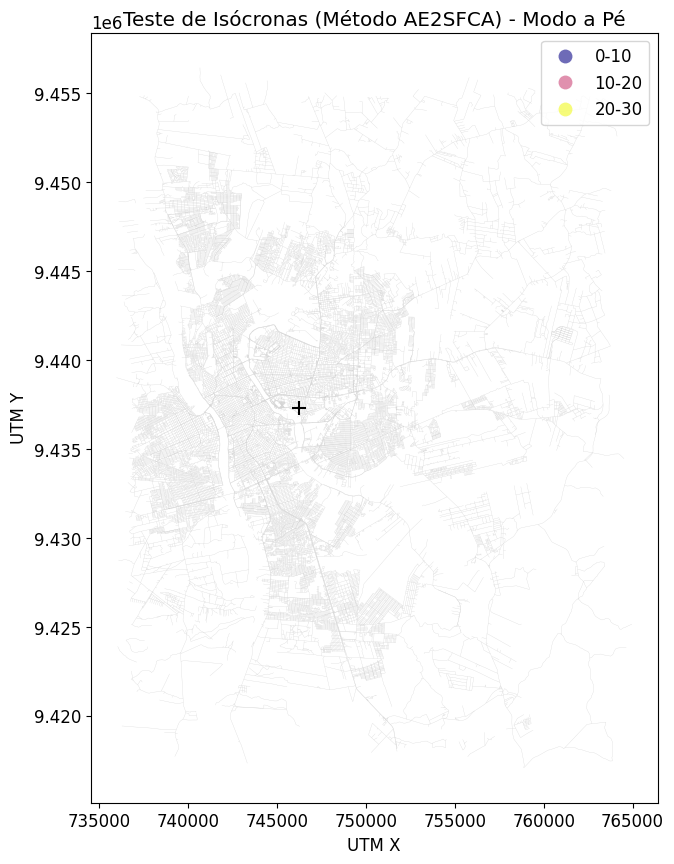

In [51]:
# Célula: Teste Visual (Prova de Conceito)
import matplotlib.pyplot as plt

print("Iniciando teste de isócrona única...")

# 1. Definir um ponto de teste (Centro do mapa)
# Pegamos o centroide da união de todas as ruas (pode demorar uns segundos)
# Ou pegamos um nó aleatório do grafo para ser mais rápido
print("Iniciando teste com coordenada manual...")

# Substitua pelos valores X (Leste) e Y (Norte) reais em metros
ubs_aleatoria = (746268.44329096, 9437291.52750973)  # UBS Por enquanto (UTM ZONA 23 Sul)


ponto_teste = Point(ubs_aleatoria)
# -----------------------------

# 2. Rodar a função para CARRO
gdf_resultado = gerar_isocronas_ubs(H, ponto_teste, modo='walk')

# 3. Plotar o Resultado
fig, ax = plt.subplots(figsize=(10, 10))

# Fundo: Ruas (Cinza claro)
gdf_road.plot(ax=ax, color='lightgray', linewidth=0.2, zorder=1)

# Isócronas (Coloridas por faixa)
# cmap='viridis_r' inverte para que o centro (0-10) seja mais "quente" ou diferente
gdf_resultado.plot(ax=ax, column='faixa', cmap='plasma', alpha=0.6, legend=True, zorder=2)

# Ponto da UBS (Preto)
ax.scatter([ponto_teste.x], [ponto_teste.y], c='black', marker='+', s=100, zorder=3, label='UBS')

plt.title("Teste de Isócronas (Método AE2SFCA) - Modo a Pé")
plt.xlabel("UTM X")
plt.ylabel("UTM Y")
plt.show()

In [40]:
gdf_resultado.head()

,faixa,tempo_min,modo,geometry
0,0-10,10,walk,"POLYGON ((743102.09 9437789.531, 742967.561 94..."
1,10-20,20,walk,"POLYGON ((743104.033 9437149.796, 742616.269 9..."
2,20-30,30,walk,"POLYGON ((743553.084 9436386.525, 742695.443 9..."


In [35]:
gdf_resultado.to_file("../dados/processados/isocrona_teste.geojson", driver="GeoJSON")

In [48]:
# Célula 8: Loop de Processamento para todas as UBS
import pandas as pd
import geopandas as gpd
from tqdm.auto import tqdm # Barra de progresso (opcional, mas muito útil)

print("Iniciando processamento em lote das 75 UBS...")

# 1. Carregar o arquivo das UBS
# Ajuste o caminho relativo conforme sua estrutura de pastas
caminho_ubs = "../dados/brutos/semplam/ubs_zu_utm.geojson"

try:
    gdf_ubs = gpd.read_file(caminho_ubs)
    print(f"Arquivo carregado! Total de UBS encontradas: {len(gdf_ubs)}")
except Exception as e:
    print(f"Erro ao carregar arquivo: {e}")
    # Pare a execução se não carregar
    raise

# 2. Verificação de Segurança (CRS)
# O grafo G e as UBS precisam estar no mesmo sistema (UTM / Metros)
# Se o G foi criado a partir do gdf_road (que convertemos para EPSG:31983),
# vamos garantir que as UBS também estejam.
crs_projeto = "EPSG:31983" 
if gdf_ubs.crs.to_string() != crs_projeto:
    print(f"Aviso: Reprojetando UBS de {gdf_ubs.crs} para {crs_projeto}...")
    gdf_ubs = gdf_ubs.to_crs(crs_projeto)

# 3. Preparar lista para guardar os resultados
resultados_acumulados = []

# 4. O Loop Principal
# tqdm cria uma barrinha de carregamento visual para você não ficar ansioso
for index, row in tqdm(gdf_ubs.iterrows(), total=len(gdf_ubs), desc="Calculando Isócronas"):
    
    # Pega a geometria (Ponto) e o ID da UBS
    # Tente identificar qual coluna tem o NOME da UBS (ex: 'nome', 'no_fantasia', 'cnes')
    # Vou assumir que existe uma coluna 'nome', se não tiver, ajustaremos.
    ponto_ubs = row.geometry
    
    # Tenta pegar o nome ou usa o índice como ID
    id_ubs = row.get('nome', row.get('NOME', f"UBS_{index}"))
    cnes_ubs = row.get('cnes', row.get('CNES', 0)) # Importante para join futuro
    
    try:
        # CHAMA NOSSA FUNÇÃO (Modo Carro como padrão, depois faremos loop de modos se quiser)
        # Se quiser fazer para TODOS os modos agora, teríamos que aninhar outro loop aqui.
        # Por enquanto, vamos focar no CARRO para validar.
        gdf_iso_temp = gerar_isocronas_ubs(G, ponto_ubs, modo='walk')
        
        # Adiciona colunas de identificação ao resultado
        # Sem isso, você terá um monte de polígonos sem saber de qual UBS são!
        gdf_iso_temp['id_ubs'] = id_ubs
        gdf_iso_temp['cnes'] = cnes_ubs
        
        resultados_acumulados.append(gdf_iso_temp)
        
    except Exception as e:
        print(f"Erro ao processar UBS {id_ubs}: {e}")
        continue

# 5. Consolidação (Juntar tudo num GeoDataFrame só)
if resultados_acumulados:
    gdf_final = pd.concat(resultados_acumulados, ignore_index=True)
    print(f"\nProcessamento concluído!")
    print(f"Total de polígonos gerados: {len(gdf_final)} (Esperado: 75 * 3 = 225)")
    
    # Exportação Final
    caminho_saida = "../outputs/vectors/isocronas_todas_ubs_ape.geojson"
    gdf_final.to_file(caminho_saida, driver="GeoJSON")
    print(f"Arquivo MESTRE salvo em: {caminho_saida}")
else:
    print("Nenhum resultado foi gerado. Verifique os erros.")

Iniciando processamento em lote das 75 UBS...
Arquivo carregado! Total de UBS encontradas: 75


Calculando Isócronas: 100%|██████████| 75/75 [00:36<00:00,  2.03it/s]



Processamento concluído!
Total de polígonos gerados: 225 (Esperado: 75 * 3 = 225)
Arquivo MESTRE salvo em: ../outputs/vectors/isocronas_todas_ubs_ape.geojson


In [50]:
# Célula: Mapa Interativo de Diagnóstico
import folium

print("Gerando mapa interativo...")

# 1. Preparar os dados para visualização (Folium precisa de Lat/Lon - EPSG:4326)
# Mas o .explore() faz a conversão sozinho se o CRS estiver setado.

# Vamos pegar apenas as UBS para não pesar o mapa, e as isócronas geradas
# (Assumindo que gdf_final e gdf_ubs estão na memória)

# Cria o mapa base focado nas isócronas
m = gdf_final.explore(
    column="tempo_min",    # Colore pelo tempo (10, 20, 30)
    cmap="plasma",         # Paleta de cores
    alpha=0.5,             # Transparência
    name="Isócronas",      # Nome na camada
    tiles="CartoDB positron" # Fundo leve
)

# Adiciona as UBS por cima (Pontos pretos)
gdf_ubs.explore(
    m=m,                   # Adiciona ao mapa 'm' criado acima
    color="black",
    marker_kwds={"radius": 4},
    name="UBS (Locais)",
    popup=["nome", "cnes"] # Mostra o nome ao clicar (ajuste a coluna se precisar)
)

# Adiciona controle de camadas
folium.LayerControl().add_to(m)

# Exibe o mapa
m

Gerando mapa interativo...
